In [1]:
import torch
import os
import cv2
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

from torchsummary import summary

In [2]:
#batch_size = 128

num_epochs = 100
batch_size = 512
image_height = 100
image_width = 100
num_channels = 3

transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.Resize((image_height, image_width)),
                                       ])

# train_set = datasets.ImageFolder(
#     root='../archive/fruits-360-original-size/fruits-360-original-size/Training',
#     transform=transform
# )

# validation_set = datasets.ImageFolder(
#     root='../archive/fruits-360-original-size/fruits-360-original-size/Validation',
#     transform=transform
# )

# test_set = datasets.ImageFolder(
#     root='../archive/fruits-360-original-size/fruits-360-original-size/Test',
#     transform=transform
# )

## Check

train_set = datasets.ImageFolder(
    root='../archive/fruits-360_dataset/fruits-360/Training',
    transform=transform
)

test_set = datasets.ImageFolder(
    root='../archive/fruits-360_dataset/fruits-360/Test',
    transform=transform
)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

#validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [3]:
train_set

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: ../archive/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [4]:
test_set

Dataset ImageFolder
    Number of datapoints: 22688
    Root location: ../archive/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [7]:
classes = train_set.classes
print(classes)
print('Class size:', len(classes))

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [8]:
images, labels = next(iter(trainloader)) 
print("images-size:", images.shape)

out = utils.make_grid(images)
print("out-size:", out.shape)

C:\Users\hejac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


images-size: torch.Size([512, 3, 100, 100])
out-size: torch.Size([3, 6530, 818])


Shape: (100, 100, 3)


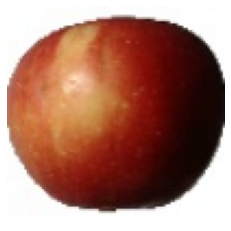

In [9]:
example_train_path = '../archive/fruits-360_dataset/fruits-360/Training/'
path = '../archive/fruits-360_dataset/fruits-360'
img = cv2.imread(example_train_path + "Apple Braeburn/0_100.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Shape:", img.shape)
plt.axis('off')
plt.imshow(img)

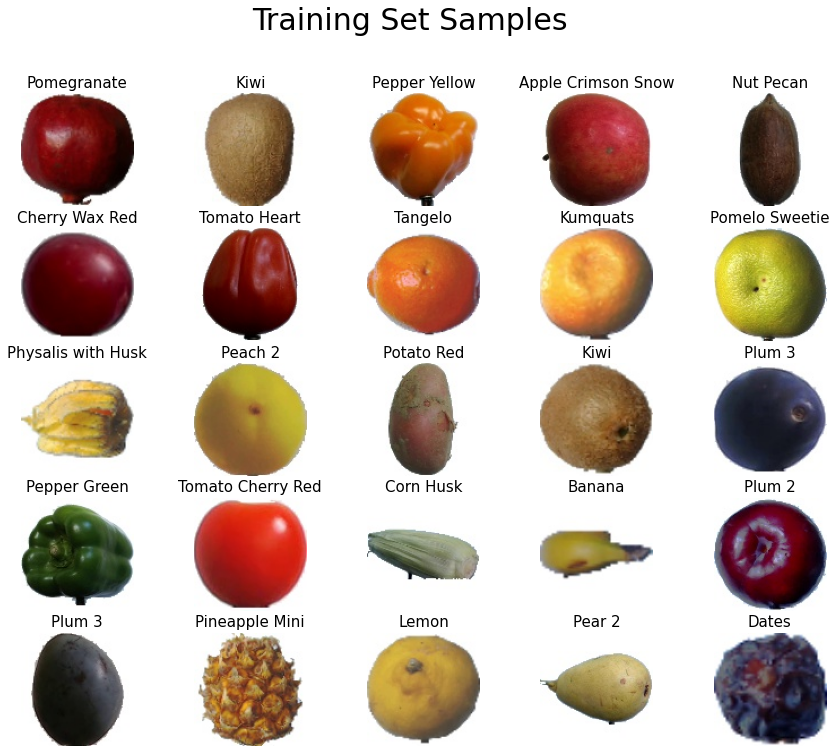

In [10]:
import random

# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = cv2.imread(samples[i][0][0])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(train_set.classes)
    rand_samples.append([random.sample([os.path.join(path+'/Training/'+classes, filename) for filename in os.listdir(path+'/Training/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [11]:
class LRScheduler():
    def __init__(self, optimizer, patience=5, min_lr=1e-7, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='min',patience=self.patience,factor=self.factor,min_lr=self.min_lr,verbose=True)
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [12]:
num_classes = len(train_set.classes)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [14]:
class Fruits_CNN(nn.Module):
    def __init__(self):
        super(Fruits_CNN, self).__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=5, stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 16*50*50

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32*25*25

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=5, stride=5)
        # 64*5*5 = 1600 >> it is in_features value for the self.linear1

        self.flatten1 = nn.Flatten()

        self.linear1 = nn.Linear(in_features=1600, out_features=512)
        self.dropout1 = nn.Dropout(p=0.25)
        self.linear2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool3(out)

        out = self.flatten1(out)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.linear2(out)

        return out

In [15]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0,save_best=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_best=save_best
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            if self.save_best:
                self.save_best_model()
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.save_best:
                self.save_best_model()
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_best_model(self):
        print(">>> Saving the current model with the best loss value...")
        print("-"*100)
        torch.save(model.state_dict(), './parameters/best_model_loss.pkl')

In [16]:
model = Fruits_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = LRScheduler(optimizer= optimizer,patience=5,min_lr=1e-7, factor=0.5)
early_stopping = EarlyStopping(patience=15, min_delta=0, save_best=True)

print(summary(model, (num_channels, image_height,image_width),batch_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [512, 16, 100, 100]           1,216
       BatchNorm2d-2        [512, 16, 100, 100]              32
              ReLU-3        [512, 16, 100, 100]               0
         MaxPool2d-4          [512, 16, 50, 50]               0
            Conv2d-5          [512, 32, 50, 50]           8,224
       BatchNorm2d-6          [512, 32, 50, 50]              64
              ReLU-7          [512, 32, 50, 50]               0
         MaxPool2d-8          [512, 32, 25, 25]               0
            Conv2d-9          [512, 64, 25, 25]          18,496
      BatchNorm2d-10          [512, 64, 25, 25]             128
             ReLU-11          [512, 64, 25, 25]               0
        MaxPool2d-12            [512, 64, 5, 5]               0
          Flatten-13                [512, 1600]               0
           Linear-14                 [5

C:\Users\hejac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv2d(input, weight, bias, self.stride,


In [84]:
from datetime import datetime
import math

In [85]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [86]:
print('***** Start Training *****')

for epoch in range(num_epochs):

    start_time = datetime.now()

    correct = 0
    iterations = 0
    training_loss = 0.0

    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _,pred = torch.max(outputs, dim=1)
        correct += (pred == labels).sum().item()
        iterations += 1

    train_accuracy.append(100 * correct / len(train_set))
    train_loss.append(training_loss / iterations)

    # Testing part
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()
    for i, data in enumerate(testloader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        testing_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        iterations += 1
    
    test_accuracy.append(100 * correct / len(test_set))
    test_loss.append(testing_loss / iterations)

    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'.format(epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

    end_time = datetime.now()
    epoch_time = (end_time - start_time).total_seconds()
    print("-"*100)
    print('Epoch Time : ', math.floor(epoch_time // 60), ':', math.floor(epoch_time % 60))
    print("-"*100)

    lr_scheduler(test_loss[-1])
    early_stopping(test_loss[-1])
    if early_stopping.early_stop:
        print('*** Early stopping ***')
        break

print('***** Finished Training *****')

***** Start Training *****
Epoch 1/100, Training Loss: 0.937, Training Accuracy: 77.163, Testing Loss: 0.203, Testing Acc: 94.504
----------------------------------------------------------------------------------------------------
Epoch Time :  11 : 46
----------------------------------------------------------------------------------------------------
>>> Saving the current model with the best loss value...
----------------------------------------------------------------------------------------------------
Epoch 2/100, Training Loss: 0.012, Training Accuracy: 99.746, Testing Loss: 0.125, Testing Acc: 97.342
----------------------------------------------------------------------------------------------------
Epoch Time :  1 : 29
----------------------------------------------------------------------------------------------------
>>> Saving the current model with the best loss value...
----------------------------------------------------------------------------------------------------
Epoc

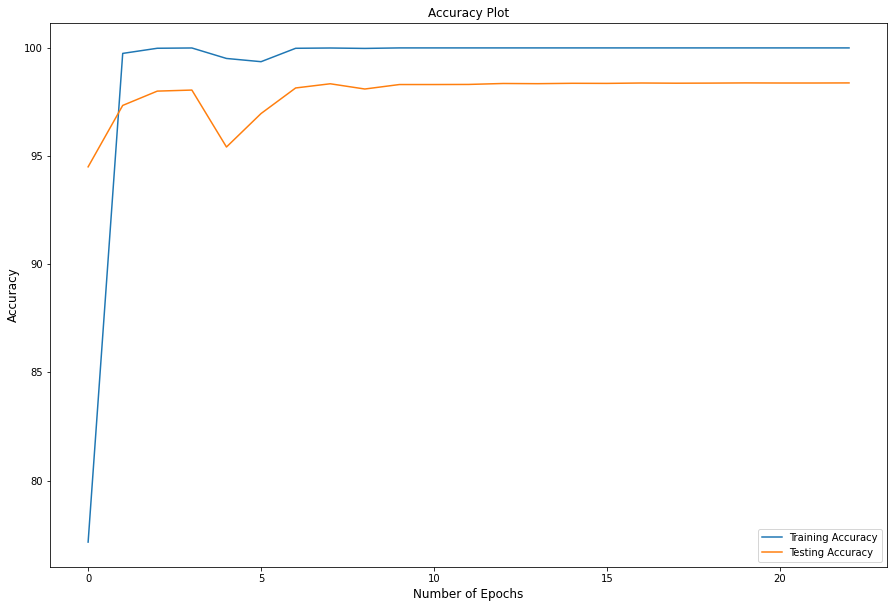

In [87]:
fig = plt.figure(figsize=(15,10))
plt.title("Accuracy Plot")
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')

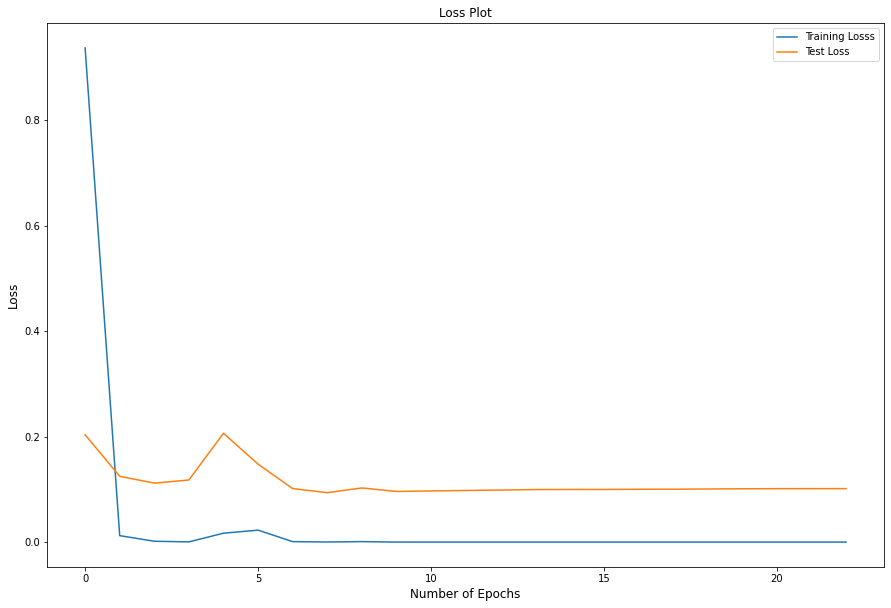

In [88]:
fig = plt.figure(figsize=(15,10))
plt.title("Loss Plot")
plt.plot(train_loss, label='Training Losss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='best')

In [17]:
model = Fruits_CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load('./parameters/best_model_loss.pkl'))
model.eval()

Fruits_CNN(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1600, out_features=512, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=5

In [18]:
from glob import glob

In [30]:
index = {idx: key for (key, idx) in train_set.class_to_idx.items()}

In [31]:
fruits = glob('../archive/fruits-360_dataset/fruits-360/Test/*/*.jpg', recursive=True)

In [32]:
def what_fruit_is_this(fruit_path):
    img = img = cv2.imread(fruit_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = torch.autograd.Variable(transform(img)).unsqueeze(0)
    output = model(x)
    prediction_idx = torch.max(output, 1)[1]
    prediction = test_set.classes[prediction_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title('Fruit: ' + prediction)

In [33]:
random.choice(fruits)

'../archive/fruits-360_dataset/fruits-360/Test\\Mangostan\\r_108_100.jpg'

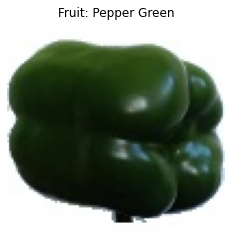

In [34]:
what_fruit_is_this(random.choice(fruits))

Computer Vision Part

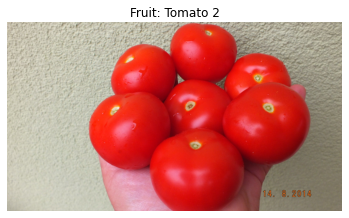

In [35]:
what_fruit_is_this('../fruits/tomatoss.jpg')

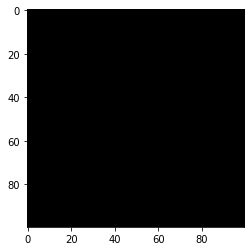

In [36]:
img = img = cv2.imread('../fruits/tomatoss.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (100, 100))

lower_blue = np.array([0,0,230])  
upper_blue = np.array([250,250,255])


mask = cv2.inRange(img, lower_blue, upper_blue)
plt.imshow(mask, cmap='gray')

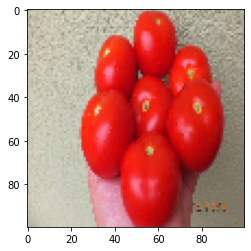

In [37]:
masked_image = np.copy(img)
masked_image[mask != 0] = [0, 0, 0]
plt.imshow(masked_image)

In [38]:
img.shape

(100, 100, 3)

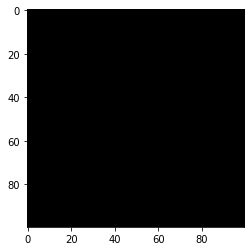

In [39]:
background_image = cv2.imread('../white.jpg')
background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
crop_background = background_image[0:100, 0:100]

crop_background[mask == 0] = [0,0,0]
plt.imshow(crop_background)

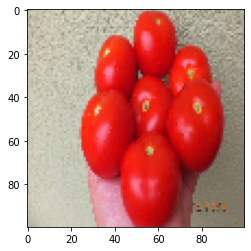

In [40]:
complete_image = masked_image + crop_background
plt.imshow(complete_image)

In [41]:
cv2.imwrite('../fruits/new_tomatos.jpg', cv2.cvtColor(complete_image, cv2.COLOR_RGB2BGR))

True

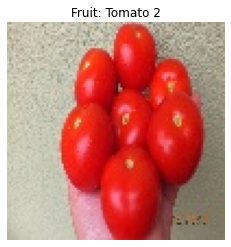

In [42]:
what_fruit_is_this('../fruits/new_tomatos.jpg')

Count number of fruits

In [43]:
import imutils

[INFO] 10 fruits detectedNone


True

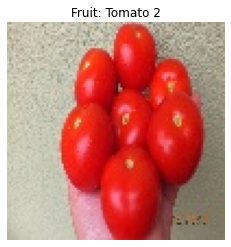

In [48]:
image = cv2.imread('../fruits/new_tomatos.jpg') #reads the image


dst = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)


rgb_image = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

new_image = cv2.medianBlur(rgb_image,5)
cv2.imwrite('median_blur.jpg',new_image)

hsv_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)

ret,th1=cv2.threshold(h,180,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imwrite('Binary_image.jpg',th1)

kernel = np.ones((5,5), dtype = "uint8")/9
bilateral = cv2.bilateralFilter(th1, 9 , 75, 75)
erosion = cv2.erode(bilateral, kernel, iterations = 6)
cv2.imwrite('mask_erosion.jpg', erosion)

cnts = cv2.findContours(th1.copy(), cv2.RETR_EXTERNAL,
 cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} fruits detected".format(len(cnts)) + str(what_fruit_is_this('../fruits/new_tomatos.jpg')))
for (i, c) in enumerate(cnts):
   ((x, y), _) = cv2.minEnclosingCircle(c)
   cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
   cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.imwrite('Contour_Image.jpg',image)

Referennce:
1. Fruits 360 on Kaggle: https://www.kaggle.com/datasets/moltean/fruits
2. PyTorch Training a classifier: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
3. Define a Neural Network in PyTorch: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html